In [34]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score


In [121]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [122]:
train_df.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


In [123]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878049 entries, 0 to 878048
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Dates       878049 non-null  object 
 1   Category    878049 non-null  object 
 2   Descript    878049 non-null  object 
 3   DayOfWeek   878049 non-null  object 
 4   PdDistrict  878049 non-null  object 
 5   Resolution  878049 non-null  object 
 6   Address     878049 non-null  object 
 7   X           878049 non-null  float64
 8   Y           878049 non-null  float64
dtypes: float64(2), object(7)
memory usage: 60.3+ MB


In [6]:
train_df.shape

(878049, 9)

In [115]:
train_df.duplicated().sum()

2323

In [124]:
train_df.drop_duplicates(keep = 'first', inplace = True)

In [9]:
train_df.shape

(875726, 9)

In [10]:
# check unique values
# we have 39 Category
train_df.nunique()

Dates         389257
Category          39
Descript         879
DayOfWeek          7
PdDistrict        10
Resolution        17
Address        23228
X              34243
Y              34243
dtype: int64

In [11]:
# LARCENY/THEFT has the most frequncey 
train_df.Category.value_counts()

LARCENY/THEFT                  174320
OTHER OFFENSES                 125960
NON-CRIMINAL                    91915
ASSAULT                         76815
DRUG/NARCOTIC                   53919
VEHICLE THEFT                   53706
VANDALISM                       44581
WARRANTS                        42145
BURGLARY                        36600
SUSPICIOUS OCC                  31394
MISSING PERSON                  25669
ROBBERY                         22988
FRAUD                           16637
FORGERY/COUNTERFEITING          10592
SECONDARY CODES                  9979
WEAPON LAWS                      8550
PROSTITUTION                     7446
TRESPASS                         7318
STOLEN PROPERTY                  4537
SEX OFFENSES FORCIBLE            4380
DISORDERLY CONDUCT               4313
DRUNKENNESS                      4277
RECOVERED VEHICLE                3132
KIDNAPPING                       2340
DRIVING UNDER THE INFLUENCE      2268
LIQUOR LAWS                      1899
RUNAWAY     

In [125]:
# extract year, month, day_of_month, day_of_week, hour from dates

train_df['Dates'] = pd.to_datetime(train_df['Dates'])
train_df['year'] = train_df['Dates'].dt.year
train_df['month'] = train_df['Dates'].dt.month
train_df['day_of_month'] = train_df['Dates'].dt.day
train_df['day_of_week'] = train_df['Dates'].dt.day_of_week
train_df['hour'] = train_df['Dates'].dt.hour
train_df.drop(['Dates', 'DayOfWeek'], axis = 1, inplace = True)


In [126]:
train_df.head()

,Category,Descript,PdDistrict,Resolution,Address,X,Y,year,month,day_of_month,day_of_week,hour
0,WARRANTS,WARRANT ARREST,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,2015,5,13,2,23
1,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,2015,5,13,2,23
2,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414,2015,5,13,2,23
3,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873,2015,5,13,2,23
4,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541,2015,5,13,2,23


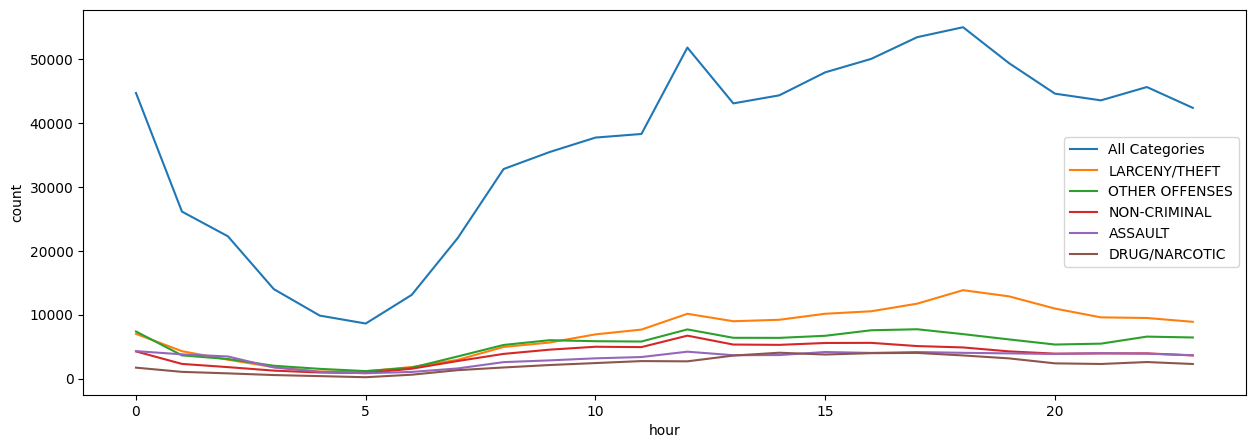

In [127]:
# see if there is any relation between time and crimes
category_count = train_df.Category.value_counts().to_frame().reset_index()
top5category = category_count.iloc[:5] 

train_df_cat = train_df.hour.value_counts().to_frame().sort_index()
plt.figure(figsize = (15, 5))
plt.plot(train_df_cat)

for item in top5category['index']:
    train_df_cat = train_df[train_df.Category == item].hour.value_counts().to_frame().sort_index()
    plt.plot(train_df_cat)
plt.legend(['All Categories'] + list(top5category['index'].values))
plt.xlabel('hour')
_ = plt.ylabel('count')

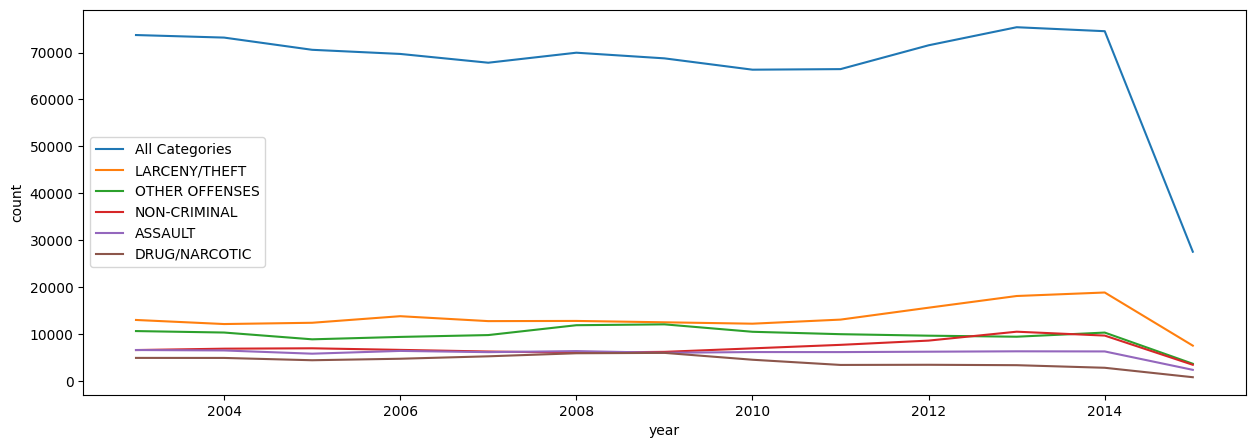

In [128]:
# see if there is any relation between years and crimes
category_count = train_df.Category.value_counts().to_frame().reset_index()
top5category = category_count.iloc[:5] 

train_df_cat = train_df.year.value_counts().to_frame().sort_index()
plt.figure(figsize = (15, 5))
plt.plot(train_df_cat)

for item in top5category['index']:
    train_df_cat = train_df[train_df.Category == item].year.value_counts().to_frame().sort_index()
    plt.plot(train_df_cat)
plt.legend(['All Categories'] + list(top5category['index'].values))
plt.xlabel('year')
_ = plt.ylabel('count')

<AxesSubplot:xlabel='PdDistrict', ylabel='Category'>

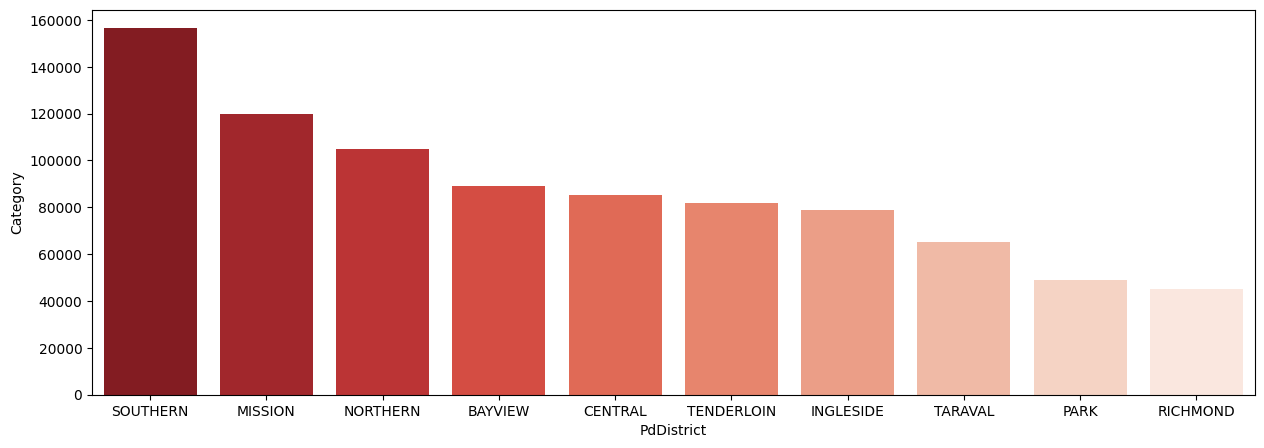

In [24]:
# Southern distrcit has the most crime frequency
df1 = train_df.groupby('PdDistrict').count().reset_index()[['PdDistrict', 'Category']].sort_values('Category', ascending = False)
plt.figure(figsize = (15, 5))
sns.barplot(x = 'PdDistrict',y = 'Category',data = df1, palette= 'Reds_r')

In [129]:
# There are 879 desctipts, we will select top 200 crime description
top200 = train_df['Descript'].value_counts()[:200].index
train_df['Descript'] = train_df['Descript'].apply(lambda x :x if x in top200 else 'other' )

In [130]:
# split the target classification and drop address column
x = train_df.drop(['Category', 'Address'], axis = 1)
y = train_df['Category']

In [131]:
# encode non-numerical data
le = LabelEncoder()
y = le.fit_transform(y)
x['Descript'] = le.fit_transform(x['Descript'])
x['PdDistrict'] = le.fit_transform(x['PdDistrict'])
x['Resolution'] = le.fit_transform(x['Resolution'])

In [132]:
# split the dataset
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.15, random_state = 1)

In [133]:
# scale the data
mms = MinMaxScaler()
x_train = mms.fit_transform(x_train)
x_test = mms.transform(x_test)

In [134]:
# build XGB model
model = XGBClassifier()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

In [135]:
accuracy_score(y_pred, y_test)

0.9592643062142677